## LSTM regression
- 시계열 데이터에 대한 예측해보기
- 세계 항공 여행 승객 수 증가 데이터, 12개월치 승객 수 이용, 다음 달의 승객수 예측
- LSTM의 output range -1~1 이므로 인풋 normalize 필요

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from keras import models, layers
import seaborn as sns

from keraspp import skeras

Using TensorFlow backend.


In [2]:
class Dataset:
    def __init__(self, fname='international-airline-passengers.csv', D=12):
        data_dn = load_data(fname=fname)
        X, y = get_Xy(data_dn, D=D)
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
        self.X, self.y = X, y
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

In [3]:
def load_data(fname='international-airline-passengers.csv'):
    dataset = pd.read_csv(fname, usecols=[1], engine='python', skipfooter=3)
    data = dataset.values.reshape(-1)
    plt.plot(data)
    plt.xlabel('Time'); plt.ylabel('#Passengers')
    plt.title('Original Data')
    plt.show()
    
    data_nomalized = (data - np.mean(data)) / np.std(data) / 5
    plt.plot(data_nomalized)
    plt.xlabel('Time'); plt.ylabel('Normalized #Passenger')
    plt.title('Normalized data by $E[]$ and $sigma$')
    plt.show()
    
    return data_nomalized

In [4]:
def get_Xy(data, D=12):
    X_list = []
    y_list = []
    N = len(data)
    assert N > D, "N should be longer than D, where N is len(data)"
    for i in range(N-D-1):
        X_list.append(data[i:i+D])
        y_list.append(data[i+D])
    X = np.array(X_list)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.array(y_list)
    print(X.shape, y.shape)
    return X, y

In [5]:
class Machine():
    def __init__(self):
        self.data = Dataset()
        shape = self.data.X.shape[1:]
        self.model = rnn_model(shape)
    
    def run(self, epochs=400):
        d = self.data
        X_train, X_test = d.X_train, d.X_test
        y_train, y_test = d.y_train, d.y_test
        X, y = d.X, d.y
        m = self.model
        h = m.fit(X_train, y_train, epochs=epochs, validation_data=[X_test, y_test], verbose=0)
        
        skeras.plot_loss(h)
        plt.title('History of training')
        plt.show()
        
        yp = m.predict(X_test)
        print('Loss', m.evaluate(X_test, y_test))
        plt.plot(yp, label='Orignal')
        plt.plot(y_test, label='Prediction')
        plt.legend(loc=0)
        plt.title('Validation Results')
        plt.show()
        
        yp = m.predict(X_test).reshape(-1)
        print('Loss:', m.evaluate(X_test, y_test))
        print(yp.shape, y_test.shape)
        
        df = pd.DataFrame()
        df['Sample'] = list(range(len(y_test))) * 2
        df['Normalized #Passengers'] = np.concatenate([y_test, yp], axis=0)
        df['Type'] = ['Original'] * len(y_test) + ['Prediction'] * len(yp)
        
        plt.figure(figsize=(7,5))
        sns.barplot(x='Sample', y='Normalized #Passengers',
                   hue='Type', data=df)
        plt.ylabel('Normalized #Passenger')
        plt.show()
        
        yp = m.predict(X)
        
        plt.plot(yp, label='Original')
        plt.plot(y, label='Prediction')
        plt.legend(loc=0)
        plt.title('All Results')
        plt.show()

In [6]:
def rnn_model(shape):
    m_x = layers.Input(shape=shape)
    m_h = layers.LSTM(10)(m_x)
    m_y = layers.Dense(1)(m_h)
    m = models.Model(m_x, m_y)
    
    m.compile('adam', 'mean_squared_error')
    m.summary()
    return m

In [7]:
def main():
    machine = Machine()
    machine.run(epochs=400)

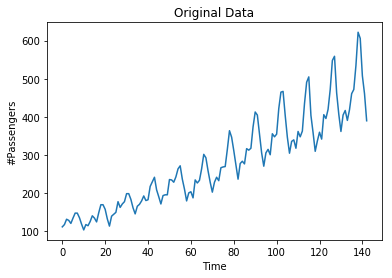

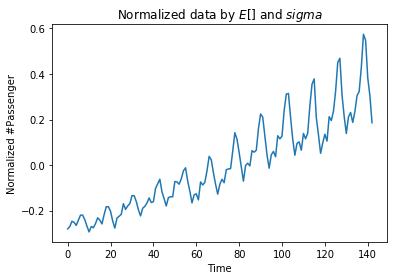

(130, 12, 1) (130,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


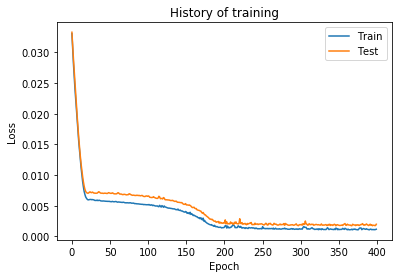

26/26 [==============================] - 0s 122us/step
Loss 0.001979802269488573


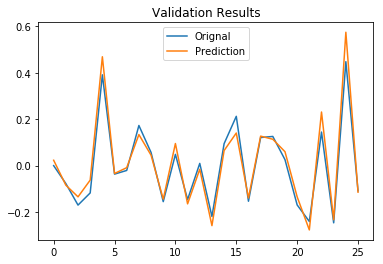

26/26 [==============================] - 0s 76us/step
Loss: 0.001979802269488573
(26,) (26,)


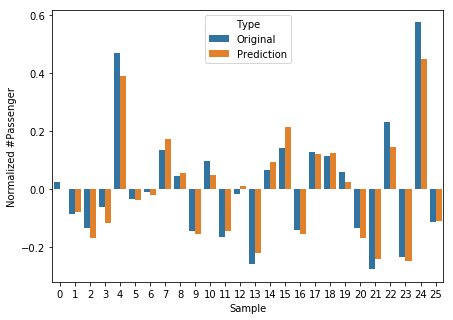

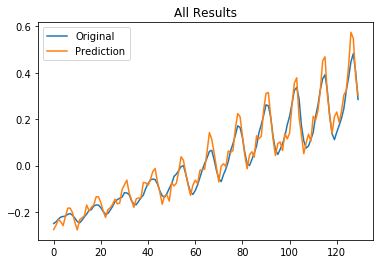

In [8]:
main()